In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import ops
from geographiclib.geodesic import Geodesic
from shapely.geometry import LineString, MultiLineString

In [2]:
# plotting modules
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline

## Vectorize Raster

In [3]:
!gdal_contour -a z -i 20 grav_29.1.10min.nc grav_29.1.10min.shp

0...10...20...30...40...50...60...70...80...90...100 - done.


## Read vector file

In [4]:
df = gpd.read_file(f'grav_29.1.10min.shp')
df.geometry = df.geometry.apply(lambda geom: MultiLineString([geom]) if geom.geom_type == 'LineString' else geom)
df = df.explode("geometry").reset_index(drop=True)
df

,ID,z,geometry
0,0,-140.0,"LINESTRING (-70.61027 80.00000, -70.61027 79.9..."
1,1,-80.0,"LINESTRING (-74.65209 80.00000, -74.65209 79.9..."
2,2,-60.0,"LINESTRING (-72.84509 80.00000, -72.84509 79.9..."
3,3,-40.0,"LINESTRING (-131.54545 80.00000, -131.54545 79..."
4,4,-40.0,"LINESTRING (-128.87539 80.00000, -128.87539 79..."
...,...,...,...
94426,94426,20.0,"LINESTRING (44.66988 -80.00000, 44.66988 -79.9..."
94427,94427,20.0,"LINESTRING (61.58345 -80.00000, 61.58345 -79.9..."
94428,94428,40.0,"LINESTRING (71.34908 -80.00000, 71.34908 -79.9..."
94429,94429,60.0,"LINESTRING (73.56495 -80.00000, 73.56495 -79.9..."


<AxesSubplot:>

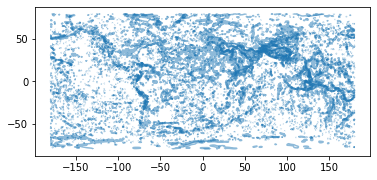

In [5]:
df.sample(10000).plot(alpha=0.5)

In [6]:
# helper function
def segmentize(line):
    return list(map(LineString, zip(line.coords[:-1], line.coords[1:])))

df['geom'] = df.geometry.apply(lambda geom: segmentize(geom))
df = df.explode("geom").reset_index(drop=True)
df = df.rename(columns={'geometry':'_','geom': 'geometry'}).drop(['_'], axis=1)
df

,ID,z,geometry
0,0,-140.0,"LINESTRING (-70.61027 80.00000, -70.61027 79.9..."
1,0,-140.0,"LINESTRING (-70.61027 79.91667, -70.58333 79.8..."
2,0,-140.0,"LINESTRING (-70.58333 79.86898, -70.41667 79.8..."
3,0,-140.0,"LINESTRING (-70.41667 79.81643, -70.25000 79.8..."
4,0,-140.0,"LINESTRING (-70.25000 79.83679, -70.08333 79.8..."
...,...,...,...
1691593,94430,80.0,"LINESTRING (78.91667 -79.86968, 78.75000 -79.8..."
1691594,94430,80.0,"LINESTRING (78.75000 -79.88793, 78.58333 -79.9..."
1691595,94430,80.0,"LINESTRING (78.58333 -79.90262, 78.41667 -79.9..."
1691596,94430,80.0,"LINESTRING (78.41667 -79.91558, 78.40217 -79.9..."


In [7]:
# for inverse geodetic calculation
geod = Geodesic.WGS84

def inverse_radian_km(geom):
    # [[lon0, lat0], [lon1, lat1]]
    coords = np.asarray(geom.coords).ravel()
    #g = geod.Inverse(float(xy0.y), float(xy0.x), float(xy1.y), float(xy1.x))
    g = geod.Inverse(coords[1], coords[0], coords[3], coords[2])
    radian = np.pi*(90 + g['azi1'])/180
    radian = radian if radian<=np.pi else radian-2*np.pi
    return (radian, g['s12']/1000.0)

def angle_radian(geom):
    return inverse_radian_km(geom)[0]

def length_km(geom):
    return inverse_radian_km(geom)[1]

df['angle'] = df.geometry.apply(angle_radian)
df['length'] = df.geometry.apply(length_km)

In [8]:
# symmetrize directions
_df = df.copy()
_df['angle'] = df.angle.apply(lambda radian: radian-np.pi if radian>=0 else np.pi+radian)
df_sym = pd.concat([df, _df])

## Rose Diagram
https://matplotlib.org/1.2.1/examples/pylab_examples/polar_bar.html

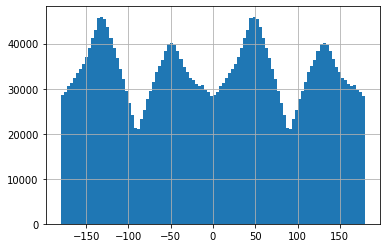

In [9]:
# make the same histogram plot as the rose diagram below
(180*df_sym['angle']/np.pi).hist(bins=100)
plt.show()

In [10]:
# Pandas 0.25.0+
angles = np.linspace(-np.pi, np.pi, 128+1, endpoint=True)
labels = (angles[1:] + angles[:-1])/2
df_sym['sector'] = labels[np.digitize(df_sym.angle, angles)-1]
df_sym_sector = df_sym.groupby(['sector']).agg(num = ('sector','count'),length = ('length','sum')).reset_index()

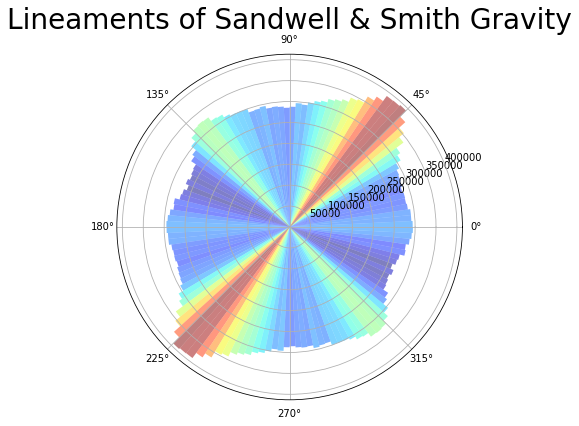

In [11]:
# force square figure and square axes looks better for polar, IMO
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

theta = df_sym_sector.sector.values
radii = df_sym_sector.length.values
width = np.diff(angles)[0]

bars = ax.bar(theta, radii, width=width, bottom=0.0)
for r,bar in zip(radii, bars):
    bar.set_facecolor( cm.jet((r-np.min(radii))/(np.max(radii)-np.min(radii))))
    bar.set_alpha(0.5)

plt.title(f'Lineaments of Sandwell & Smith Gravity', fontsize=28)
plt.savefig(f'IsoLineaments of Sandwell & Smith Gravity.jpg', \
            bbox_inches='tight', dpi=150, pil_kwargs={'quality': 95})
plt.show()